<a href="https://colab.research.google.com/github/RachitBansal/RedditFlairDetector/blob/master/3_Modelling_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DL Models for Reddit Flair Detection

In this notebook, we will train and test various DL Models on r/India subreddit data [collected](https://colab.research.google.com/drive/18kM91eTDQ7FlJvQ5oZeR_1kW77kc4HM1#scrollTo=7DtIFLibMBiI) and [preprocessed](https://colab.research.google.com/drive/1Ee_jw9_awzBUfF923tx5yfC6hsGIyvaL) previously.


In [0]:
import pandas as pd
import numpy as np

In [0]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


## LSTM

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchtext import data
import torchtext
import re

In [0]:
torch.backends.cudnn.deterministic = True

In [0]:
TEXT = data.Field(tokenize='spacy',batch_first=True,include_lengths=True, lower = True, )
LABEL = data.LabelField(dtype = torch.float,batch_first=True, lower = True)

In [0]:
df = pd.read_csv('drive/My Drive/rMIDAS_bal_2.csv')

In [0]:
df.head()

,created_utc,id,link_flair_text,num_comments,selftext,title,url
0,1.518180e+09,7wd78f,Politics,0,None,Nehru Thug Life,i redd it tiqhn co f png
1,1.552281e+09,azpdkm,Science/Technology,0,None,Ten questions that cannot be answered by science,www eternalhindutva com Ten questions that can...
2,1.545422e+09,a8dqbe,AskIndia,0,None,Waah modiji waah,www youtube com channel UCfM o q hiCgkBpjmLCmJ g
3,1.417681e+09,2o8spg,Non-Political,2,None,Sailing to Agra on Yamuna to be reality soon: ...,zeenews india com news india sailing to agra o...
4,1.424275e+09,2wbliw,[R]eddiquette,1,How serious the outburst is ? What are initial...,Advice and preventive measures for swine flu,www reddit com r india comments wbliw advice a...


In [0]:
fields = [(None, None), (None, None), ('flair', LABEL), (None, None), (None, None), ('title', TEXT), (None, None)]
training_data=data.TabularDataset(path = 'drive/My Drive/rMIDAS_bal_2.csv', format = 'csv', fields = fields, skip_header = True)

print(vars(training_data.examples[3]))

{'flair': 'non-political', 'title': ['sailing', 'to', 'agra', 'on', 'yamuna', 'to', 'be', 'reality', 'soon', ':', 'gadkari']}


In [0]:
for i in range(5):
  print(vars(training_data.examples[i]))

{'flair': 'politics', 'title': ['nehru', 'thug', 'life']}
{'flair': 'science/technology', 'title': ['ten', 'questions', 'that', 'can', 'not', 'be', 'answered', 'by', 'science']}
{'flair': 'askindia', 'title': ['waah', 'modiji', 'waah']}
{'flair': 'non-political', 'title': ['sailing', 'to', 'agra', 'on', 'yamuna', 'to', 'be', 'reality', 'soon', ':', 'gadkari']}
{'flair': '[r]eddiquette', 'title': ['advice', 'and', 'preventive', 'measures', 'for', 'swine', 'flu']}


In [0]:
train_data, valid_data = training_data.split(split_ratio=0.7)

In [0]:
vectors = torchtext.vocab.Vectors('wiki-news-300d-1M.vec', cache = './drive/My Drive/')

100%|█████████▉| 999142/999994 [02:07<00:00, 8579.43it/s]

In [0]:
TEXT.build_vocab(train_data,min_freq=3, vectors = vectors)  
LABEL.build_vocab(train_data)

print("Size of topic vocab:",len(TEXT.vocab))

print("Size of flair vocab:",len(LABEL.vocab))

print(TEXT.vocab.freqs.most_common(11))  

print(LABEL.vocab.freqs.most_common(14))

print(TEXT.vocab.stoi)

In [0]:
labels = len(LABEL.vocab)

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

b_sz = 128

train_loader, val_loader = data.BucketIterator.splits(
    (train_data, valid_data),
    batch_size = b_sz,
    sort_key = lambda x: len(x.title),
    sort_within_batch=True,
    device = device)

In [0]:
import torch.nn as nn

class model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim = 12, n_layers = 2, bidir = True, dropout = 0.2):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm = nn.LSTM(embedding_dim,
                           hidden_dim,
                           num_layers=n_layers,
                           bidirectional=bidir,
                           dropout=dropout,
                           batch_first=True)
        
        self.dense = nn.Linear(hidden_dim * 2, output_dim)
        self.softmax = nn.Softmax()
        
    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, batch_first=True)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        dense_outputs=self.dense(hidden)
        outputs=self.softmax(dense_outputs)
        
        return outputs

In [0]:
vocab_size = len(TEXT.vocab)
embedding_dim = 300
num_hidden_nodes = 32
num_output_nodes = labels
dropout = 0.2

model_ = model(vocab_size, embedding_dim, num_hidden_nodes, num_output_nodes, dropout = dropout)

In [0]:
print(model_)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model_):,} trainable parameters')

pretrained_embeddings = TEXT.vocab.vectors
model_.embedding.weight.data.copy_(pretrained_embeddings)

print(pretrained_embeddings.shape)

model(
  (embedding): Embedding(32633, 300)
  (lstm): LSTM(300, 32, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (dense): Linear(in_features=64, out_features=12, bias=True)
  (softmax): Softmax(dim=None)
)
The model has 9,901,272 trainable parameters
torch.Size([32633, 300])


In [0]:
import torch.optim as optim

optimizer = optim.Adam(model_.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

def accuracy(preds, y):
    counts = 0
    for i in range(preds.shape[0]):
      counts += (torch.max(preds[i], 0)[1] == y[i]).float()
      
    return counts/preds.shape[0]
    
model_ = model_.to(device)
criterion = criterion.to(device)

In [0]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()  
    
    for batch in iterator:
        
        optimizer.zero_grad()

        text, text_lengths = batch.title
        flair = batch.flair

        text = text.to(device)
        flair = flair.type(torch.LongTensor).to(device)

        predictions = model(text, text_lengths).squeeze()

        try:
          loss = criterion(predictions, flair)
          acc = accuracy(predictions, flair)
        except:
          continue

        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()  
        epoch_acc += acc.item()

    return epoch_loss / (len(iterator)-1), epoch_acc / (len(iterator)-1)

In [0]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0

    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:
        
            text, text_lengths = batch.title
            flair = batch.flair

            text = text.to(device)
            flair = flair.type(torch.LongTensor).to(device)
            
            predictions = model(text, text_lengths).squeeze()
            
            try:
              loss = criterion(predictions, flair)
              acc = accuracy(predictions, flair)
            except:
              continue
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / (len(iterator)-1), epoch_acc / (len(iterator)-1)

In [0]:
N_EPOCHS = 20
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
     
    train_loss, train_acc = train(model_, train_loader, optimizer, criterion)
    
    valid_loss, valid_acc = evaluate(model_, val_loader, criterion)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_.state_dict(), 'saved_weights.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc:.3f}')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


	Train Loss: 1.905 | Train Acc: 0.715
	 Val. Loss: 2.044 | Val. Acc: 0.578
	Train Loss: 1.900 | Train Acc: 0.721
	 Val. Loss: 2.044 | Val. Acc: 0.577
	Train Loss: 1.896 | Train Acc: 0.725
	 Val. Loss: 2.044 | Val. Acc: 0.578
	Train Loss: 1.891 | Train Acc: 0.729
	 Val. Loss: 2.041 | Val. Acc: 0.580
	Train Loss: 1.886 | Train Acc: 0.734
	 Val. Loss: 2.039 | Val. Acc: 0.582
	Train Loss: 1.882 | Train Acc: 0.739
	 Val. Loss: 2.039 | Val. Acc: 0.583
	Train Loss: 1.879 | Train Acc: 0.742
	 Val. Loss: 2.038 | Val. Acc: 0.584
	Train Loss: 1.876 | Train Acc: 0.744
	 Val. Loss: 2.040 | Val. Acc: 0.582
	Train Loss: 1.873 | Train Acc: 0.747
	 Val. Loss: 2.040 | Val. Acc: 0.582
	Train Loss: 1.871 | Train Acc: 0.750
	 Val. Loss: 2.037 | Val. Acc: 0.585
	Train Loss: 1.867 | Train Acc: 0.753
	 Val. Loss: 2.035 | Val. Acc: 0.587
	Train Loss: 1.864 | Train Acc: 0.756
	 Val. Loss: 2.035 | Val. Acc: 0.587
	Train Loss: 1.860 | Train Acc: 0.760
	 Val. Loss: 2.034 | Val. Acc: 0.588
	Train Loss: 1.858 | Trai

In [0]:
!nvidia-smi

In [0]:
for batch in train_loader:
      optimizer.zero_grad()   
      
      text, text_lengths = batch.title   
      
      predictions = model_(text, text_lengths).squeeze()
      loss = criterion(predictions, batch.flair.type(torch.LongTensor))
      
      loss.backward()

## Transformer Based Models


### Preparing the Data for Tranformer Training and Evaluation


In [0]:
!pip install transformers
!pip install seqeval
!pip install scipy
!pip install simpletransformers
!pip install pytorch-nlp
!pip install tensorboardx

In [0]:
import torch
import torchnlp
from torchnlp.encoders import LabelEncoder
from sklearn.model_selection import train_test_split
from multiprocessing import cpu_count

In [0]:
df = pd.read_csv('./drive/My Drive/rMIDAS_bal_2.csv')

In [0]:
encoder = LabelEncoder(df['link_flair_text'])

In [0]:
def func(x):
  z = np.zeros(12, dtype = int)
  z[x-1] = 1
  return tuple(z)

In [0]:
def prepare_data(df, flairs = 'link_flair_text', title = ['title'], drop = ['created_utc', 'id','link_flair_text','num_comments','selftext','title','url'], train = False):
  df_s = df
  df_s['text'] = ''
  for tit in title:
    df_s['text'] += df[tit]
    df_s['text'] += " "
  df_s['labels'] = pd.Series(encoder.batch_encode(list(df[flairs]))).apply(func)
  df_s = df_s.drop(drop, 'columns')
  train_df, eval_df = train_test_split(df_s, test_size=0.2)
  
  if(train):
    return train_df, eval_df
  else:
    return eval_df

In [0]:
train_df, eval_df = prepare_data(df, title = ['title', 'url'], train=True)

In [0]:
eval_df = eval_df.reset_index()
train_df = train_df.reset_index()
eval_df = eval_df.drop('index', 'columns')
train_df = train_df.drop('index', 'columns')

In [0]:
train_df['text'][0]

'DURGA DEVELOPERS - BANGALORE Reviews, Projects, Address www commonfloor com durga petals bangalore review feedback pcrf kfiqf '

In [0]:
train_df.shape

(235306, 2)

In [0]:
args = {
    "output_dir": "outputs/",
    "cache_dir": "cache/",
    "best_model_dir": "outputs/best_model/",

    "fp16": False,
    "fp16_opt_level": "O1",
    "max_seq_length": 128,
    "train_batch_size": 128,
    "eval_batch_size": 128,
    "gradient_accumulation_steps": 1,
    "num_train_epochs": 1,
    "weight_decay": 0,
    "learning_rate": 1e-4,
    "adam_epsilon": 1e-8,
    "warmup_ratio": 0.06,
    "warmup_steps": 0,
    "max_grad_norm": 1.0,
    "do_lower_case": False,

    "logging_steps": 50,
    "evaluate_during_training": False,
    "evaluate_during_training_steps": 2000,
    "evaluate_during_training_verbose": False,
    "use_cached_eval_features": False,
    "save_eval_checkpoints": True,
    "no_cache": False,
    "save_model_every_epoch": True,
    "tensorboard_dir": None,

    "overwrite_output_dir": True,
    "reprocess_input_data": True,

    "process_count": cpu_count() - 2 if cpu_count() > 2 else 1,
    "n_gpu": 1,
    "silent": False,
    "use_multiprocessing": True,

    "wandb_project": None,
    "wandb_kwargs": {},

    "use_early_stopping": True,
    "early_stopping_patience": 3,
    "early_stopping_delta": 0,
    "early_stopping_metric": "eval_loss",
    "early_stopping_metric_minimize": True,

    "manual_seed": None,
    "encoding": None,
    "config": {},
}

### DistilBERT

In [0]:
from simpletransformers.classification import MultiLabelClassificationModel

model = MultiLabelClassificationModel('distilbert', 'distilbert-base-cased', num_labels=12, args = args)

In [0]:
model.train_model(train_df, show_running_loss = True)

Running loss: 0.256300

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.126141



In [0]:
result, model_outputs, wrong_predictions = model.eval_model(eval_df)

In [0]:
print(result)

{'LRAP': 0.7908233900852227, 'eval_loss': 0.1348466330572315}


In [0]:
i = np.random.randint(eval_df.shape[0])
print(encoder.decode(torch.tensor(model_outputs[i].argmax()+1)))
print(eval_df['text'].values[i])

Policy/Economy
Airfares may go up on govt plans to raise airport charges by 10% www livemint com Companies TuUm BkjdEL Mrb lulsHN Airfares may go up on govt plans to raise airport charges by html 


In [0]:
%cp -r /content/outputs/checkpoint-5226-epoch-2 ./drive/My\ Drive/distilbert/

In [0]:
from simpletransformers.classification import MultiLabelClassificationModel

model = MultiLabelClassificationModel('distilbert', 'distilbert-base-uncased', num_labels=24, args = args)

In [0]:
model.train_model(train_df, show_running_loss = True)

In [0]:
result, model_outputs, wrong_predictions = model.eval_model(eval_df)

In [0]:
print(result)

{'LRAP': 0.7272260123327972, 'eval_loss': 0.08534275728643453}


In [0]:
i = np.random.randint(eval_df.shape[0])
print(encoder.decode(torch.tensor(model_outputs[i].argmax()+1)))
print(eval_df['text'].values[i])

Business/Finance
SoftBank to invest $1.4 billion in India's Paytm in bet on demand for mobile money


### RoBERTA

In [0]:
from simpletransformers.classification import MultiLabelClassificationModel

model = MultiLabelClassificationModel('roberta', 'distilroberta-base', num_labels=12, args = args)

In [0]:
model.train_model(train_df, show_running_loss = True)

In [0]:
result, model_outputs, wrong_predictions = model.eval_model(eval_df)

In [0]:
print(result)

{'LRAP': 0.7870777352851993, 'eval_loss': 0.13750761371591816}


In [0]:
i = np.random.randint(eval_df.shape[0])
print(encoder.decode(torch.tensor(model_outputs[i].argmax()+1)))
print(eval_df['text'].values[i])

In [0]:
torch.save(model, './drive/My Drive/model_robbert_4.h5')
torch.save(model.state_dict(), './drive/My Drive/model_robbert_6.pt')

In [0]:
i = np.random.randint(eval_df.shape[0])
print(encoder.decode(torch.tensor(model_outputs[i].argmax()+1)))
print(eval_df['text'].values[i])

Business/Finance
Anti CAA NCR in Pune today, more than 1 lac protested


In [0]:
%cp -r /content/outputs/checkpoint-2613-epoch-1 ./drive/My\ Drive/distilbert/

## ALBERT

In [0]:
from simpletransformers.classification import MultiLabelClassificationModel

model = MultiLabelClassificationModel('albert', 'albert-large-v1', num_labels=12, args = args)

In [0]:
model.train_model(train_df, show_running_loss = True)

In [0]:
result, model_outputs, wrong_predictions = model.eval_model(eval_df)

## Plotting ROC Curves

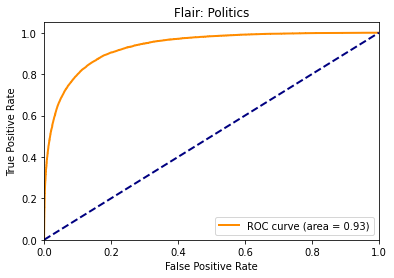

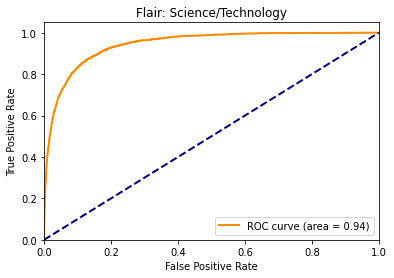

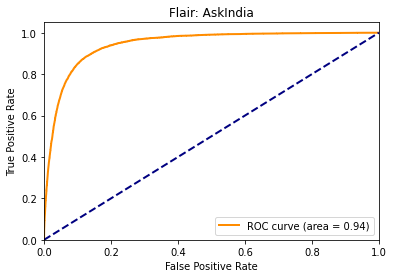

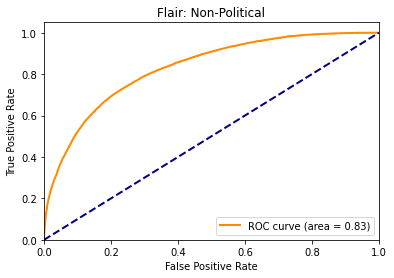

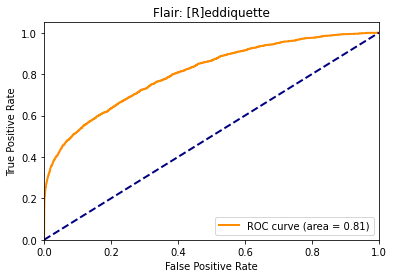

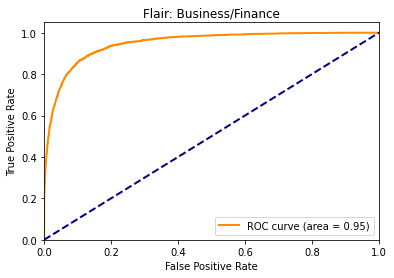

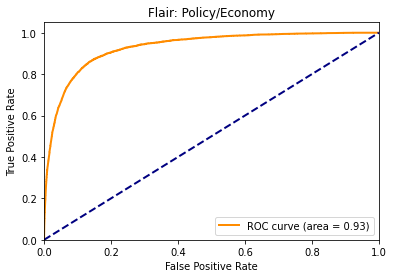

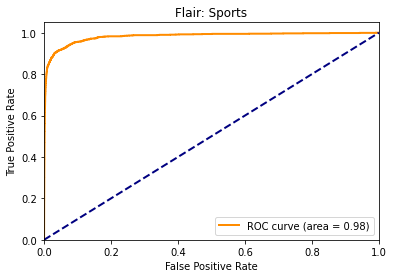

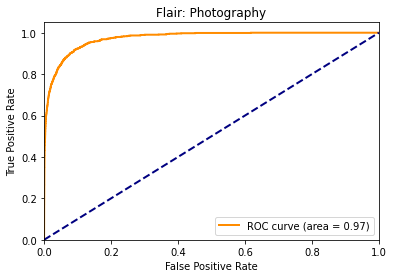

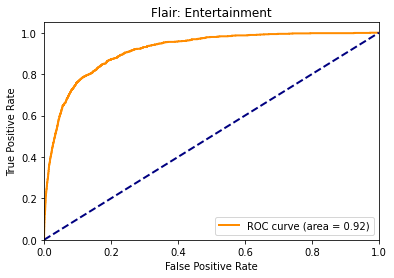

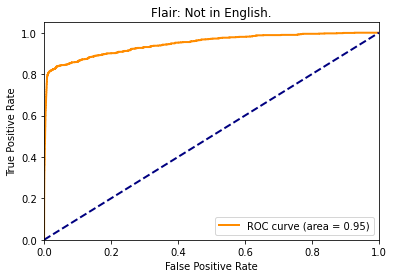

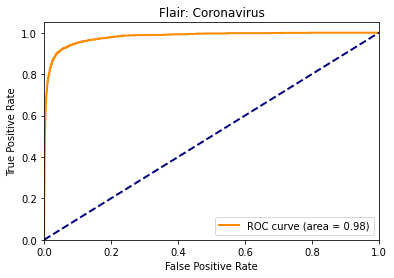

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# def roc_curve(y_score=model_outputs, y_test=y_test, n_classes = 12, col=2):
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

for col in range(12):
  plt.figure()
  lw = 2
  plt.plot(fpr[col], tpr[col], color='darkorange',
          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[col])
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Flair: ' + str(encoder.decode(torch.tensor(col+1))))
  plt.legend(loc="lower right")
  plt.savefig('./drive/My Drive/MIDAS_ROC/DistilBERT' + str(col+1) + '.png')
plt.show()